# Project Overview
1. **Objective**: Project housing demand in Texas with focus in Houston metropolitan area

2. **Design**: Use "existing home sales" to as metric to measure housing demand, train model to predict forward "existing home sales"

3. **data/signals** 
    - data indicates demand: employment, population, income, wage
    - market data impact demand: median house price, mortgage rate
    - market data indicates supply: inventory, housing starts
    - location specific data impact demand: energy price (major industry in Texas), focused MSA level data (Houston/Dallas/San Antonio, top 3 MSA based on population and economic activities)
    - seasonality data impact demand: month/quarter

4. **feature engineering rationale**: 
    - propose to create the following three type of features
        1. YoY change of signals: change of raw signals between current and prior year and it is independent of seasonality
        2. ratio between raw signal and prior 24 months rolling mean: feature meant to capture market sentiment around some economic data, e.g. inventory level at 2 year high might indicate overbuild and potential downward pressure on housing price and future housing demand
        3. ratio between raw signal and historical mean: feature meat to capture market condition based on some economic data, e.g. unemployment rate at historical low could indicate the economy is recovering from recession and potential increasing future demand for housing
    - one-hot encode categorical features: seaonality and location features

5. **initial feature selection**
    - select one type of feature of each feature category based on correlation with forward existing home sales

6. **model selection**
    - propose to use ridge regression for the following reasons
        - majority of features are continuous
        - time series data with limited data point
        - prediction problem with a continuous label
        - parametric model with ability to decompose prediction

7. **hyperparameter optimizaton**
    - optimize L2 regularization parameter based on prediction accuracy for Houston MSA on cross validation set

8. **evaluate model performance**
    - compute mean absolute percentage error (MAPE) on test set

9. **key findings**
    - Based on the current model results, real estate market condition, population growth, employment condition, wage growth, borrowing rate are major driver of housing demand
    - the model seems to be a bit under-predict in terms of number of forward existing home sales across all three MSA and vintages, combined with consistent gap between training error and cross validation error, indicating high bias problem, so one should look for more features which could help explain the gap


# Future Development
1. **data source**
    - macro: GDP, durable goods order, consumer confidence index, inflation, stock market condition, etc.
    - micro/market specific: mortgage volume, mortgage rate, mortgage underwriting standard, student loan volume, rent price, price spread between new and existing home, etc.
    - alternatives: Zillow/Trulia inquiry or search data, Google searching trend, new product line launch from major developer, policy change encouraging home ownership, etc.
2. **model selection**
    - if convert prediction to classification of demand (high/medium/low), many non-parametric models could be experimented (Random Forest or SVM+kernel)
    - if sufficient data and time are available, RNN could be experimented

In [56]:
# -*- coding: UTF-8 -*-
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
plt.style.use('ggplot')

# load & clean raw datasets

In [3]:
# load datasets
meta = {}
for fn in os.listdir('data/clean'):
    k=fn.split('.')[0]
    meta[k]=pd.read_csv('data/clean/'+fn)

In [4]:
# defin UDF
def msa_key(row):
    if 'dallas' in row['msa'].lower():
        return 'D'
    elif 'houston' in row['msa'].lower():
        return 'H' 
    elif 'antonio' in row['msa'].lower():
        return 'S'

In [5]:
# clean Texas A&M datasets
for k in ['sales', 'emp', 'permit', 'pop']:
    df=meta[k]
    df['msa_key'] = df.apply(msa_key, axis=1)
    if 'date' in df.columns:
        df['date_key'] = pd.to_datetime(df.date, format='%b-%Y')
        df['year']=df['date_key'].map(lambda x: x.to_pydatetime().year)
        df['month']=df['date_key'].map(lambda x: x.to_pydatetime().month)
        df['day']=df['date_key'].map(lambda x: x.to_pydatetime().day)
    meta[k]=df

In [6]:
# clean zillow datasets
for k in ['med_list_z', 'med_rent_z']:#, n in zip([med_list_z, med_rent_z],['med_list_p', 'med_rent_p']):
    df=meta[k]
    df = df.set_index('date').stack().reset_index();
    df.columns = ['date', 'msa', k.replace('_z', '_p')]
    df['msa_key'] = df.apply(msa_key, axis=1)
    if 'date' in df.columns:
        df['date_key'] = pd.to_datetime(df.date, format='%Y-%m')
        df['year']=df['date_key'].map(lambda x: x.to_pydatetime().year)
        df['month']=df['date_key'].map(lambda x: x.to_pydatetime().month)
        df['day']=df['date_key'].map(lambda x: x.to_pydatetime().day)
    meta[k]=df

In [7]:
# clean Fed datasets
for k in ['wage', 'income', 'wti']:
    df = meta[k]
    if 'date' in df.columns:
            df['date_key'] = pd.to_datetime(df.date, format='%b-%Y')
            df['year']=df['date_key'].map(lambda x: x.to_pydatetime().year)
            df['month']=df['date_key'].map(lambda x: x.to_pydatetime().month)
            df['day']=df['date_key'].map(lambda x: x.to_pydatetime().day)
    meta[k]=df
df=meta['libor']
df['date_key']=pd.to_datetime(df.date, format='%m/%d/%Y')
df['year']=df['date_key'].map(lambda x: x.to_pydatetime().year)
df['month']=df['date_key'].map(lambda x: x.to_pydatetime().month)
df['day']=df['date_key'].map(lambda x: x.to_pydatetime().day)
meta['libor']=df[['year','month', 'libor12']].groupby(['year','month']).mean().reset_index()

In [41]:
# join cleaned datasets
raw_features = ['year', 'month', 'msa_key', \
                'p_med', 'months_inventory', 'employmentTotal', 'unemploymentRate', \
                'f1units', 'f24units', 'f5units', 'population', 'med_list_p', 'med_rent_p', \
                'West South Central', 'libor12', 'oil_p', 'hh_inc']
raw_label = ['year', 'month', 'msa_key', 'sales', 'date_key']
df_join = meta['sales']\
            .merge(meta['emp'], on=['year', 'month', 'msa_key'], how='left')\
            .merge(meta['permit'], on=['year', 'month', 'msa_key'], how='left')\
            .merge(meta['pop'], on=['year', 'msa_key'], how='left')\
            .merge(meta['med_list_z'], on=['year', 'month', 'msa_key'], how='left')\
            .merge(meta['med_rent_z'], on=['year', 'month', 'msa_key'], how='left')\
            .merge(meta['wage'], on=['year', 'month'], how='left')\
            .merge(meta['libor'], on=['year', 'month'], how='left')\
            .merge(meta['wti'], on=['year', 'month'], how='left')\
            .merge(meta['income'], on=['year'], how='left')
df_X=df_join[raw_features]
df_y=df_join[raw_label]

# feature engineering

In [42]:
# self join to get YoY change of features
df_X_prev = df_X.copy()
df_X_prev['year']=df_X_prev['year'].map(lambda x: x+1)
df_X=df_X.merge(df_X_prev, how='left', on=['year', 'month', 'msa_key'], suffixes=('_curr', '_prev'))

In [43]:
# compute three type of derived features for each raw feature
# 1. YoY change 2. current rate/price over 24-month rolling average 3. current rate/price over history to date average
lvl_f=['p_med', 'employmentTotal', 'population', 'med_list_p', 'med_rent_p', 'oil_p', 'hh_inc']
rate_f=['months_inventory', 'f1units', 'f24units', 'f5units', 'unemploymentRate', 'West South Central', 'libor12']
# type 1
for f in lvl_f:
    df_X[f+'_g']=df_X.apply(lambda r: (r[f+'_curr']/r[f+'_prev']-1), axis=1)
for f in rate_f:
    if f=='West South Central':
        df_X['wage_growth_g']=df_X.apply(lambda r: (r[f+'_curr']-r[f+'_prev']), axis=1)
    else:
        df_X[f+'_g']=df_X.apply(lambda r: (r[f+'_curr']-r[f+'_prev']), axis=1)
# type 2&3
for f in lvl_f + rate_f:
    if f=='West South Central':
        df_X['wage_growth_r24']=df_X.groupby('msa_key')[f+'_curr'].apply(pd.rolling_mean, 24, 1)
        df_X['wage_growth_r']=df_X[f+'_curr']/df_X['wage_growth_r24']
        df_X['wage_ind_curr']=df_X[f+'_curr']/df_X[f+'_curr']
        s1 = df_X.groupby('msa_key')[f+'_curr'].cumsum();
        s2 = df_X.groupby('msa_key')['wage_ind_curr'].cumsum();
        df_X['wage_growth_h']=df_X[f+'_curr']/(s1/s2)
    else:
        df_X[f+'_r24']=df_X.groupby('msa_key')[f+'_curr'].apply(pd.rolling_mean, 24, 1)
        df_X[f+'_r']=df_X[f+'_curr']/df_X[f+'_r24']
        s1 = df_X.groupby('msa_key')[f+'_curr'].cumsum();
        s2 = df_X.groupby('msa_key')[f+'_curr'].cumcount()+1;
        df_X[f+'_h']=df_X[f+'_curr']/(s1/s2)    

In [44]:
# prepare datasets for model
feature_list=[c for c in df_X.columns if (('_curr' not in c)&('_prev' not in c))]
df=df_X[feature_list].merge(df_y, on=['year', 'month', 'msa_key'])

In [45]:
# use long history, drop Zillow datasets, drop NA
long_feature = [c for c in df.columns if 'med_list_' not in c and 'med_rent_' not in c]
df_long=df[long_feature].dropna()
df_short=df.dropna()

In [46]:
# create and join forward sales
df_long_y=df_long[['sales', 'msa_key', 'date_key']].copy()
df_long_y['date_key']=df_long_y['date_key'].map(lambda x: x - pd.DateOffset(months=1))
df_long_y=df_long_y.rename(columns = {'sales':'sales_fwd'})

# model df
df_long = df_long_y.merge(df_long, on=['date_key', 'msa_key'])

# initial feature selection

In [47]:
# prepare datasets for feature selection
f_list=[c for c in df_long.columns if ('_r24' not in c)&(c<>'sales')]
label = 'sales_fwd'
date_list = ['year', 'month', 'date_key']
msa = 'msa_key'
features= [f for f in f_list if f not in [label] + date_list + [msa]]

data = df_long[f_list]
period = df_long[date_list]

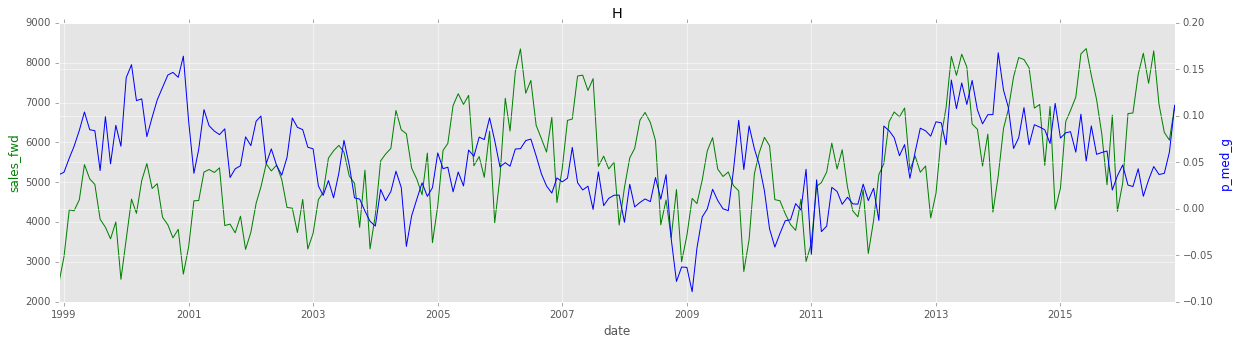

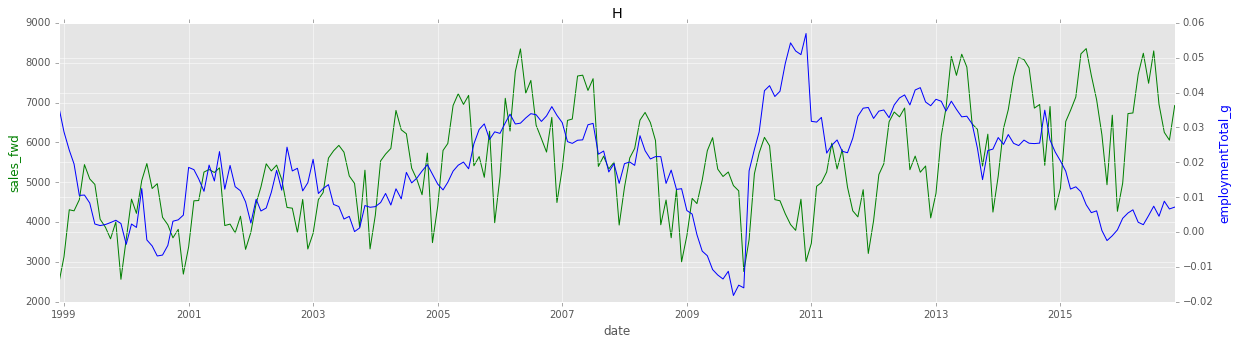

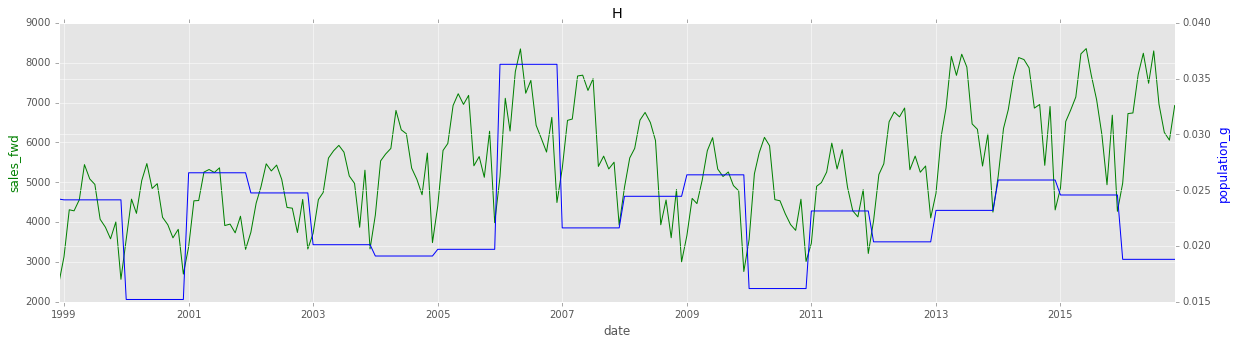

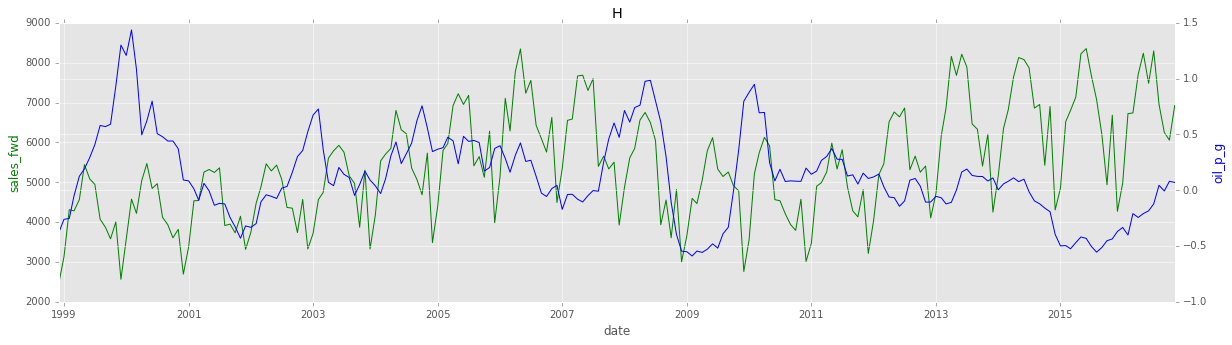

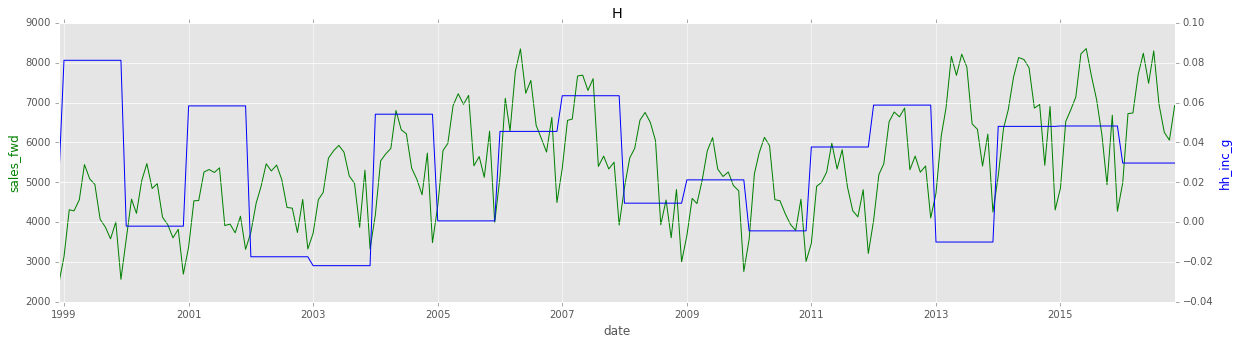

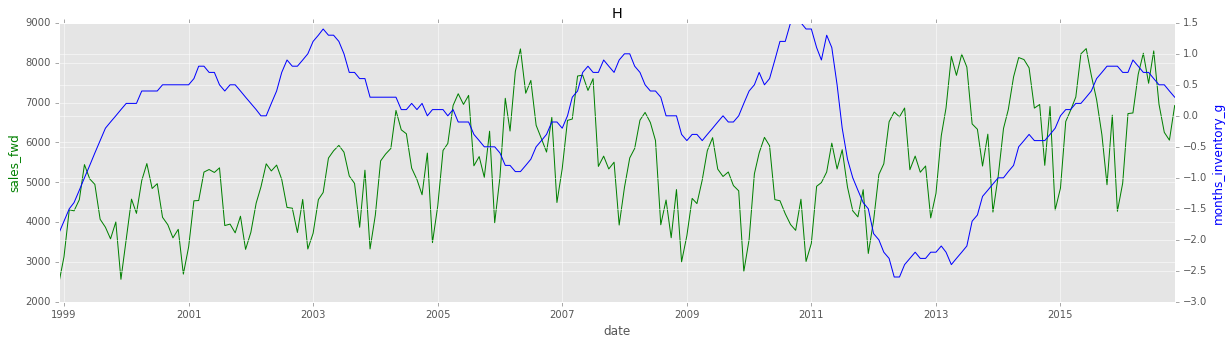

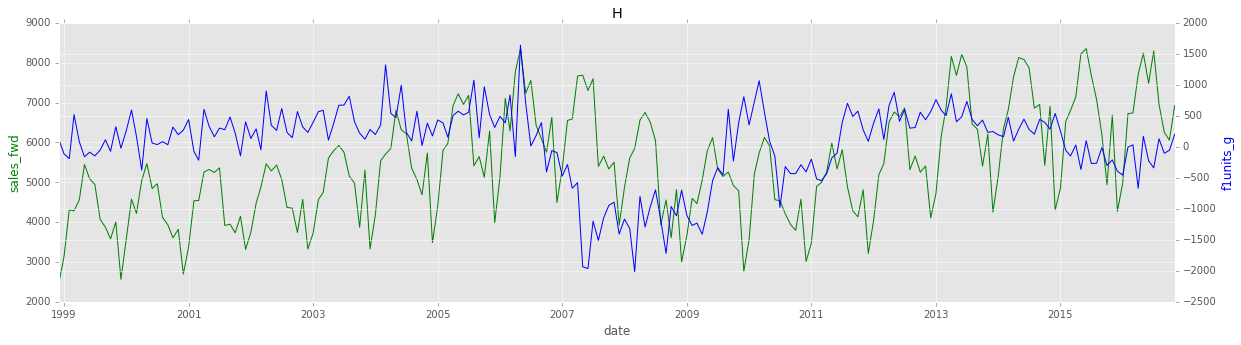

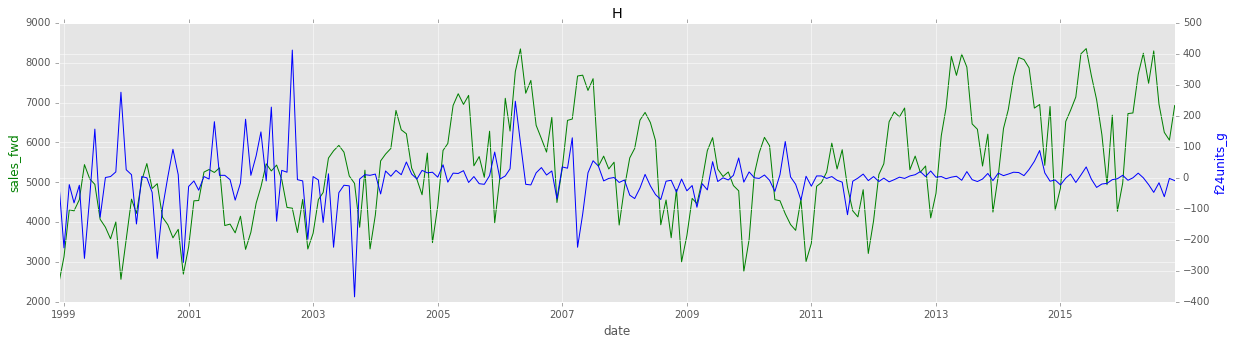

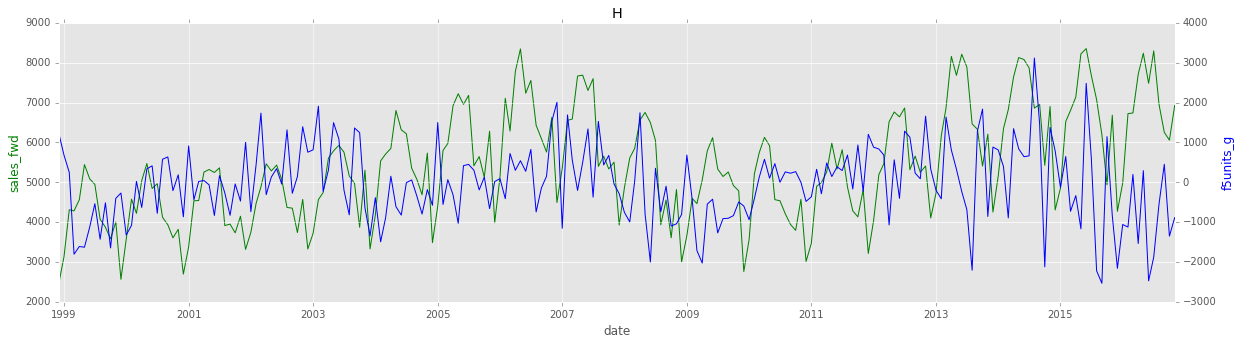

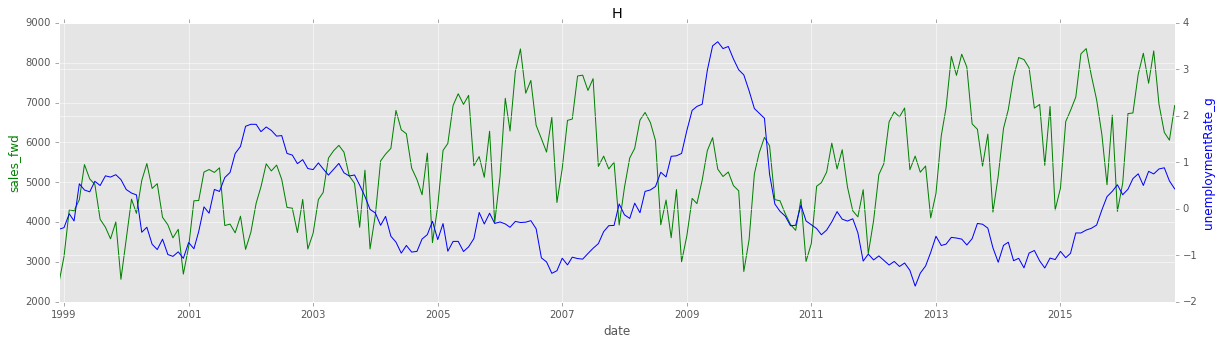

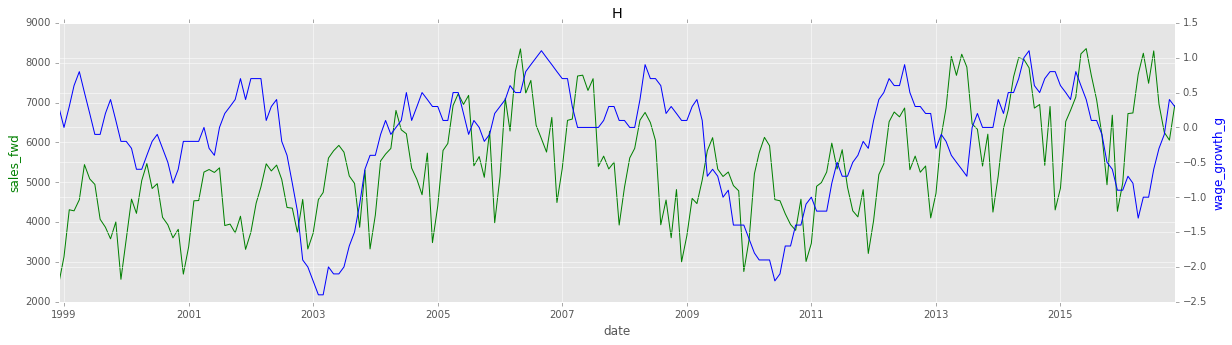

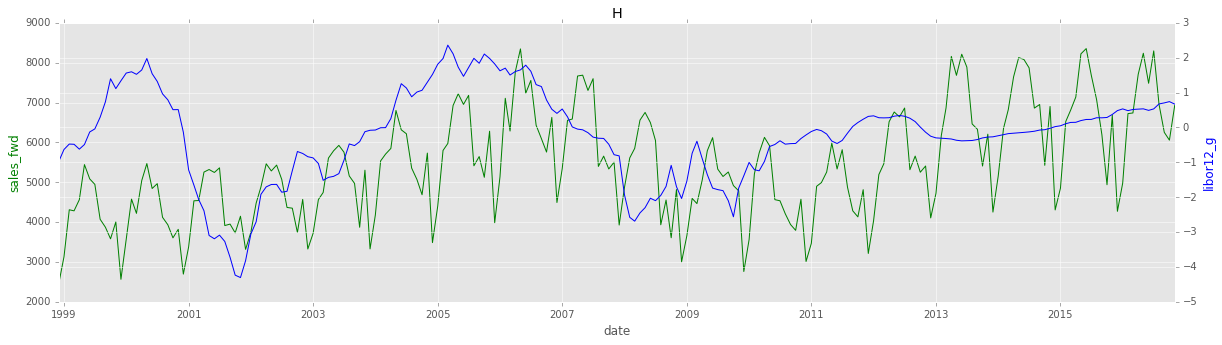

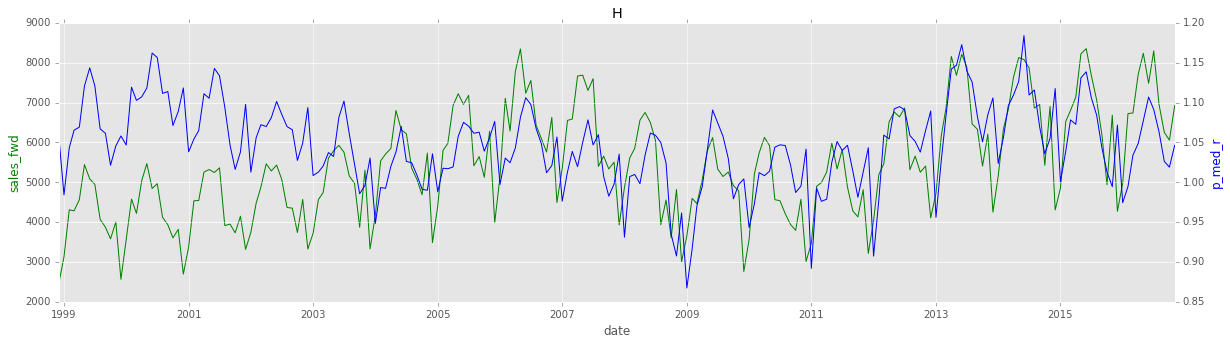

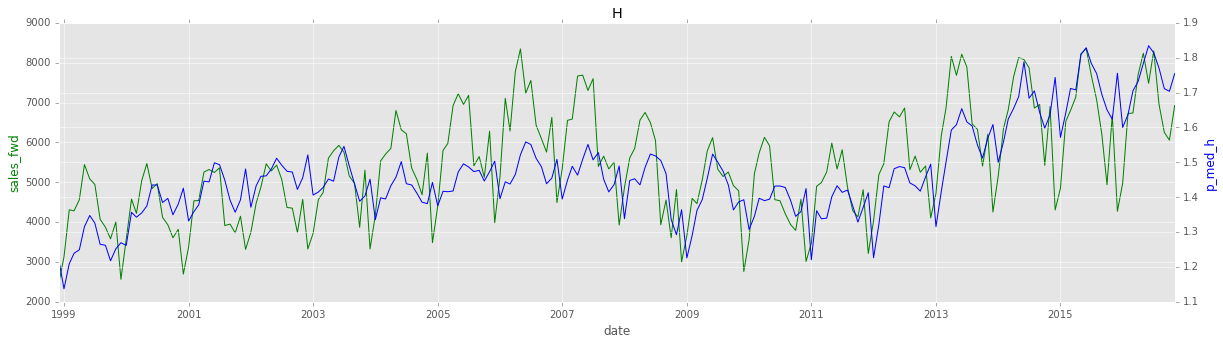

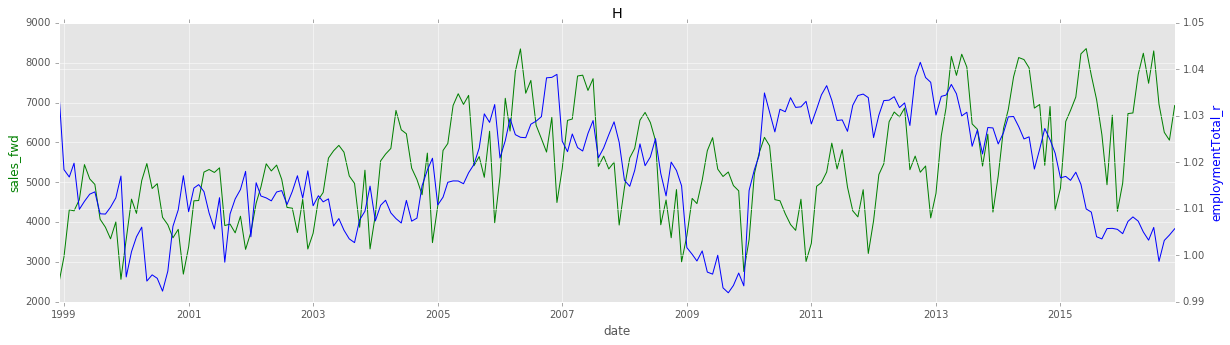

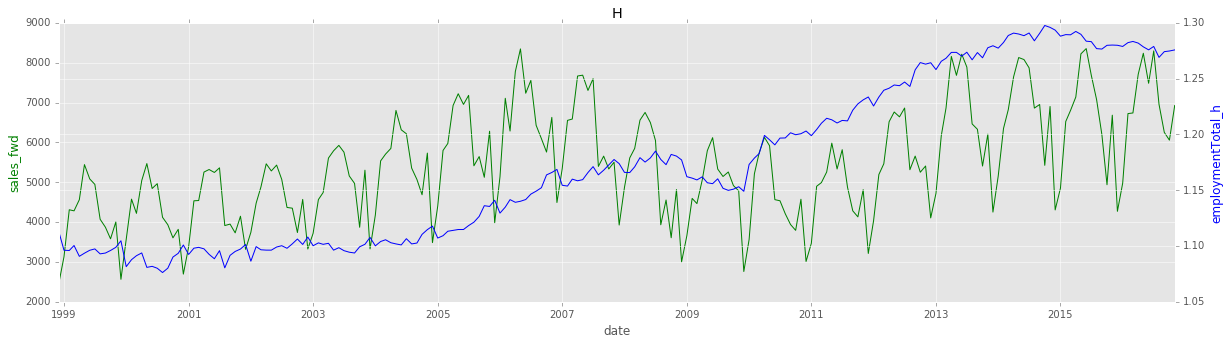

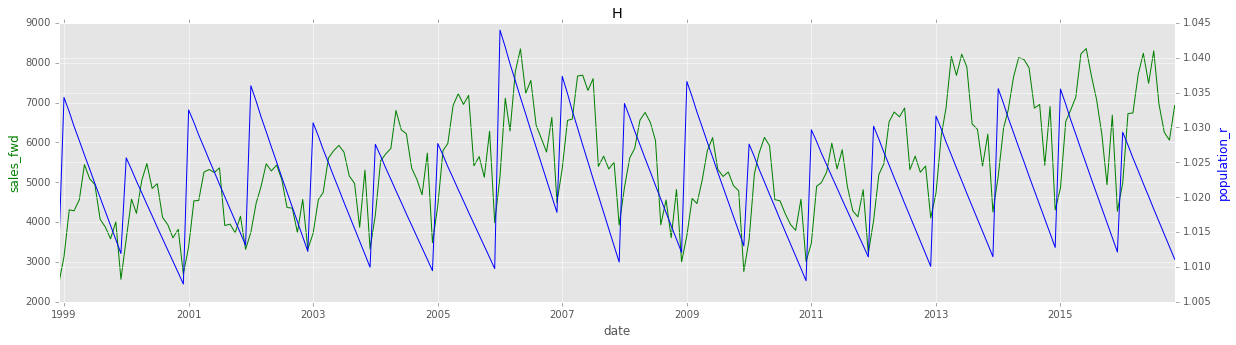

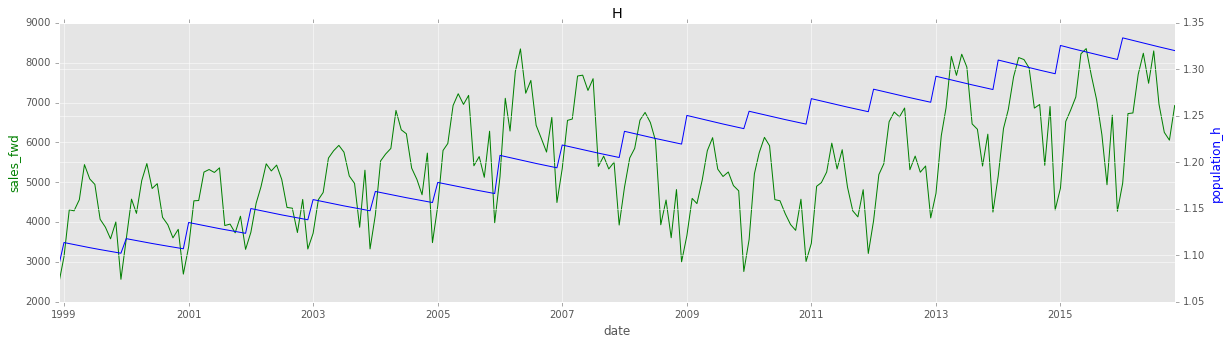

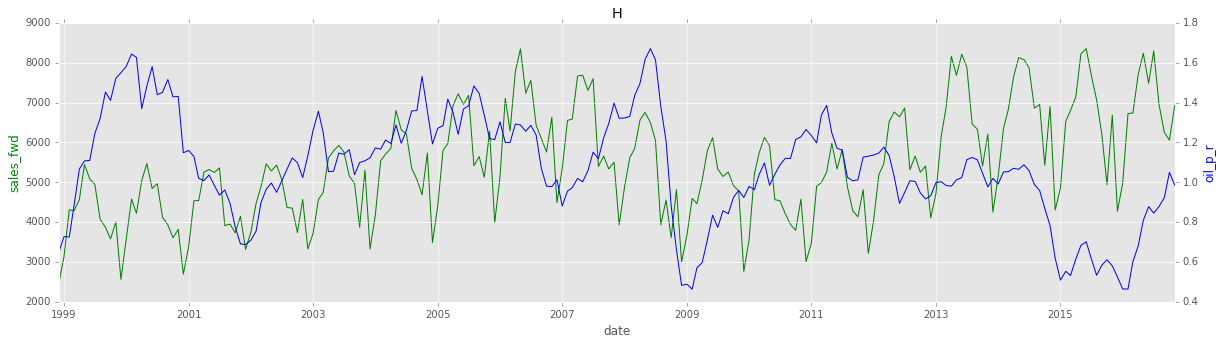

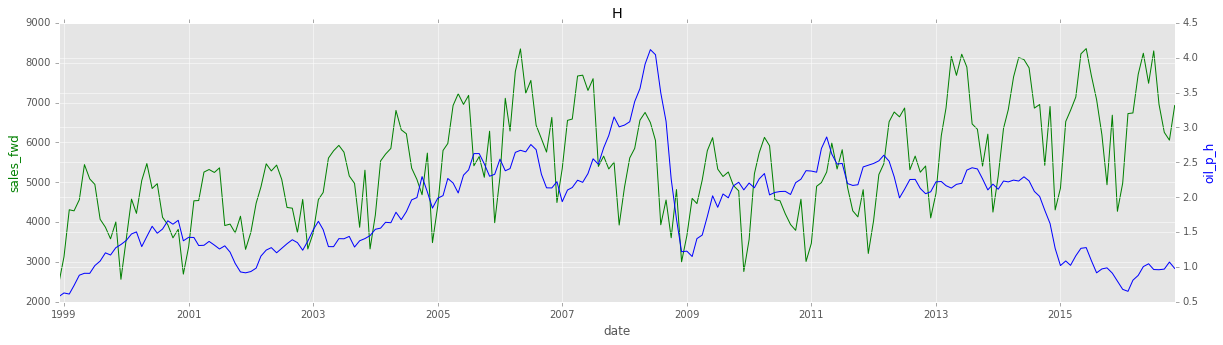

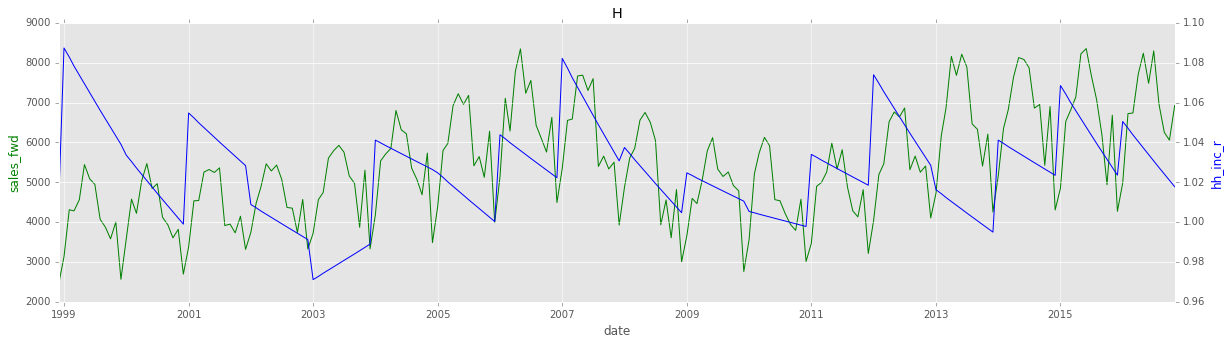

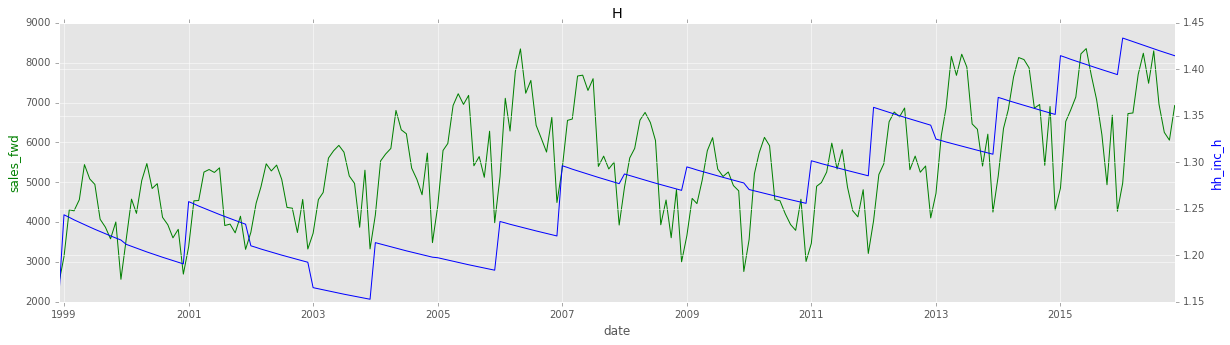

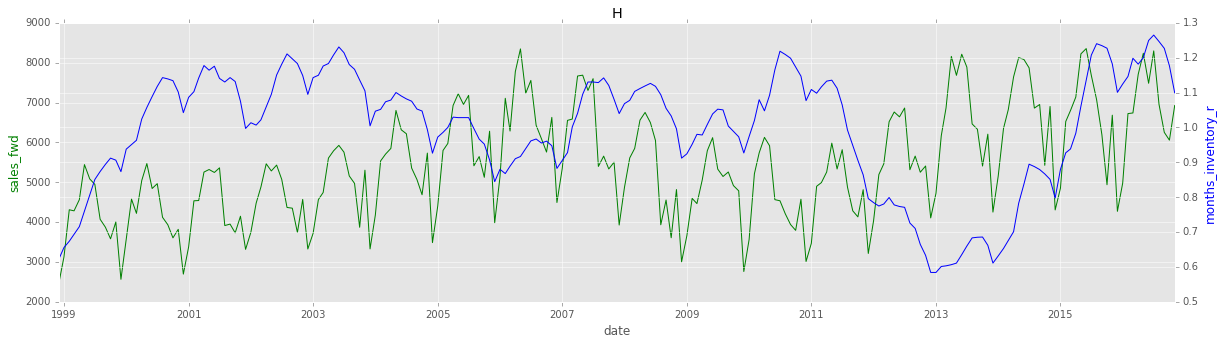

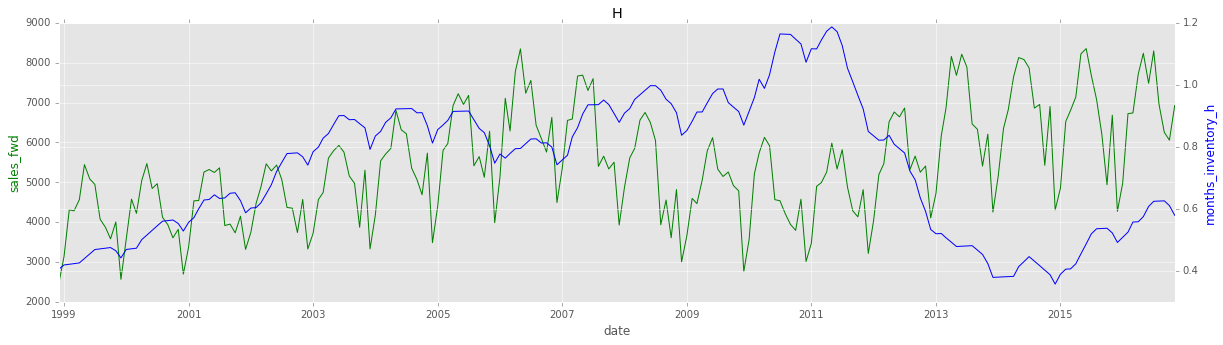

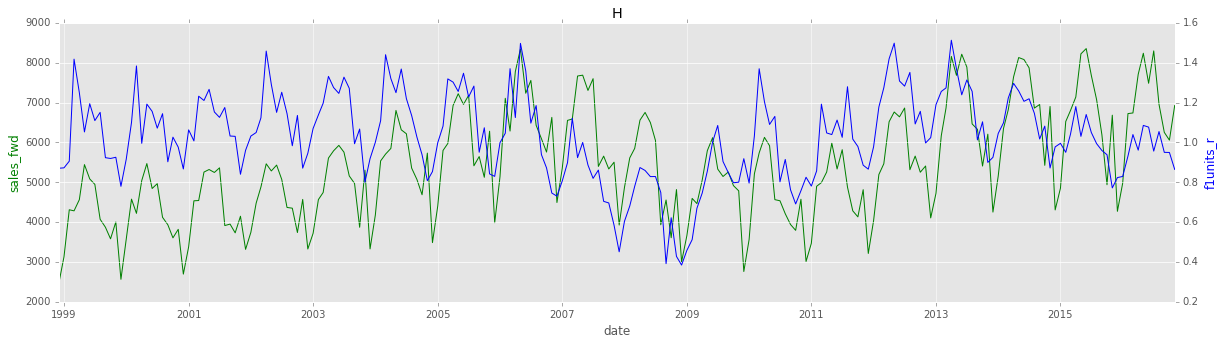

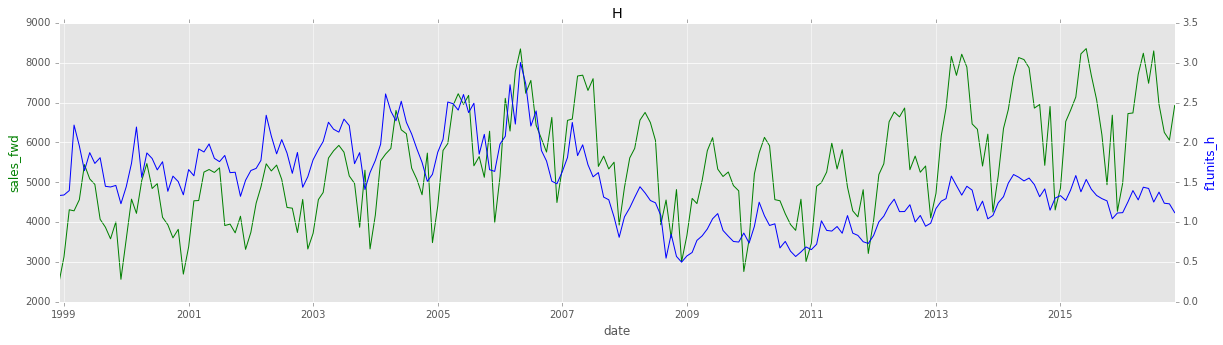

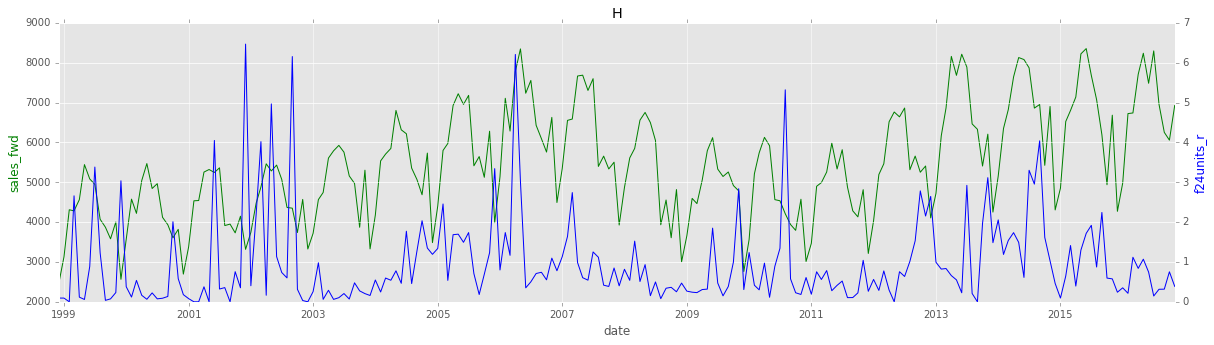

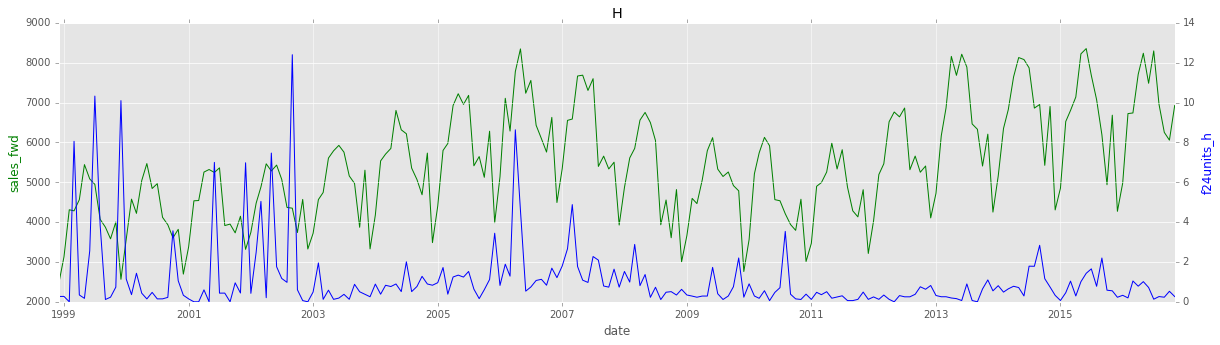

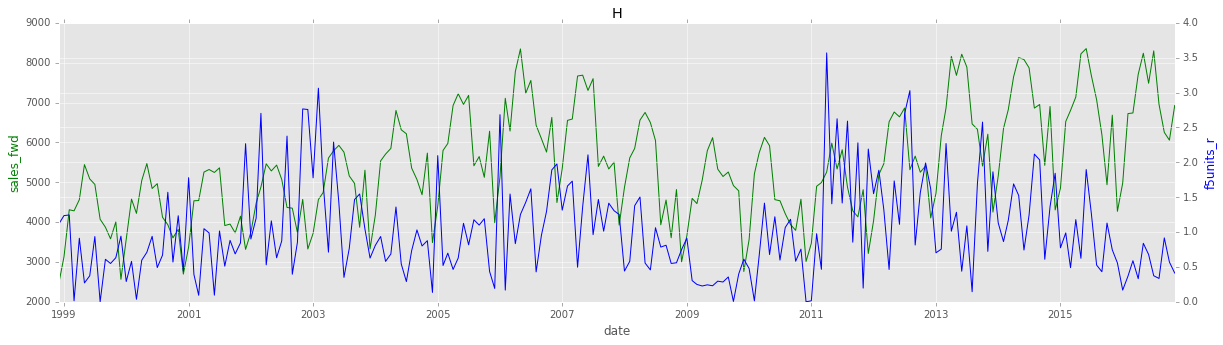

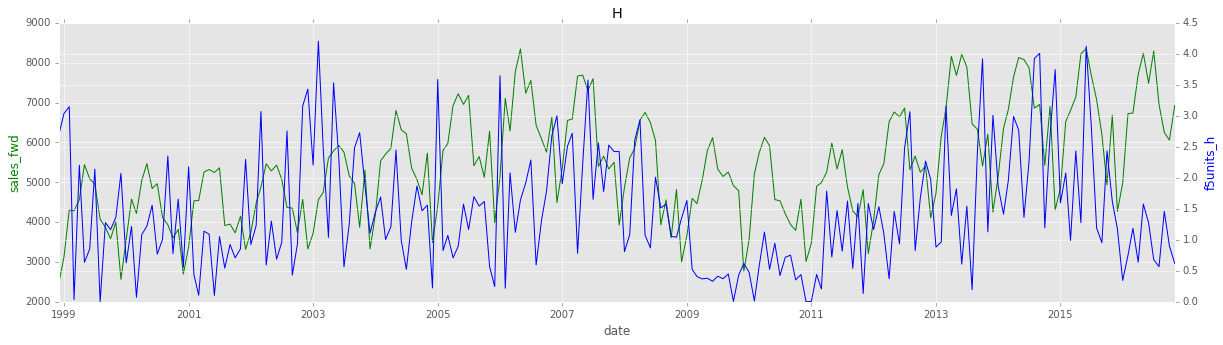

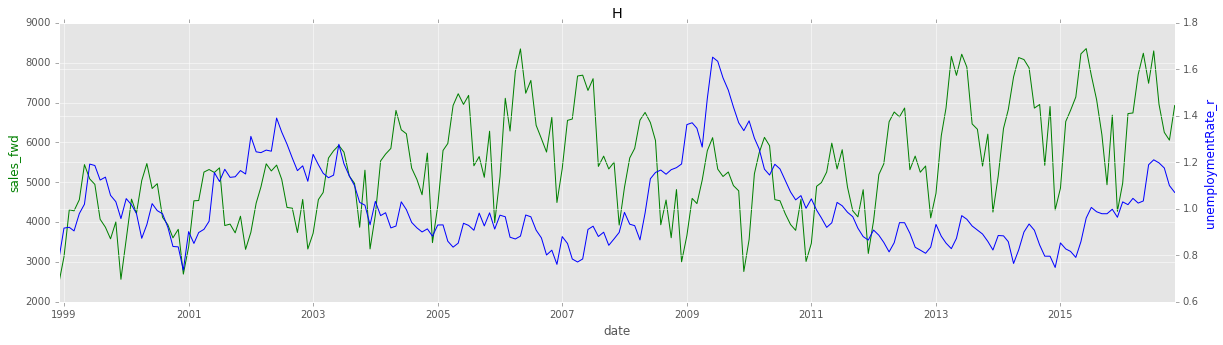

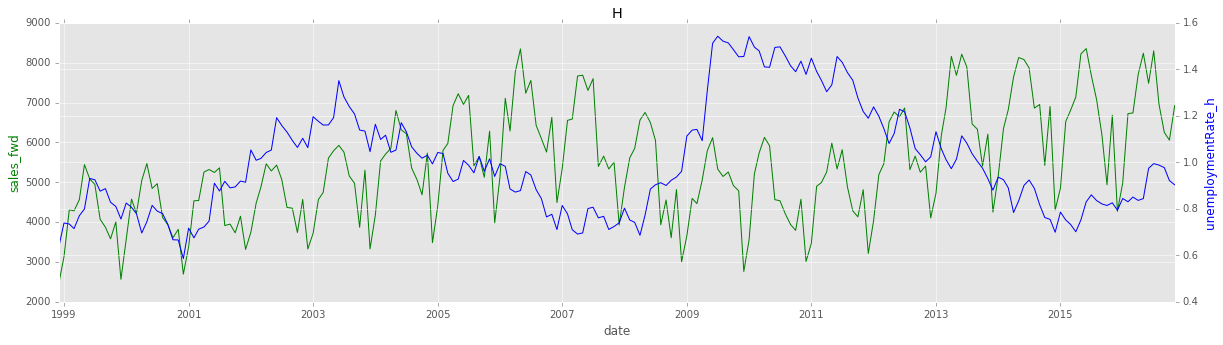

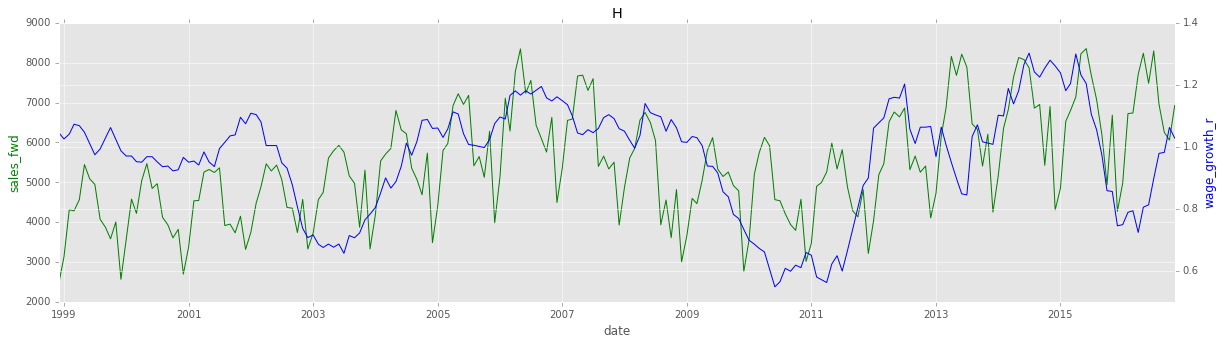

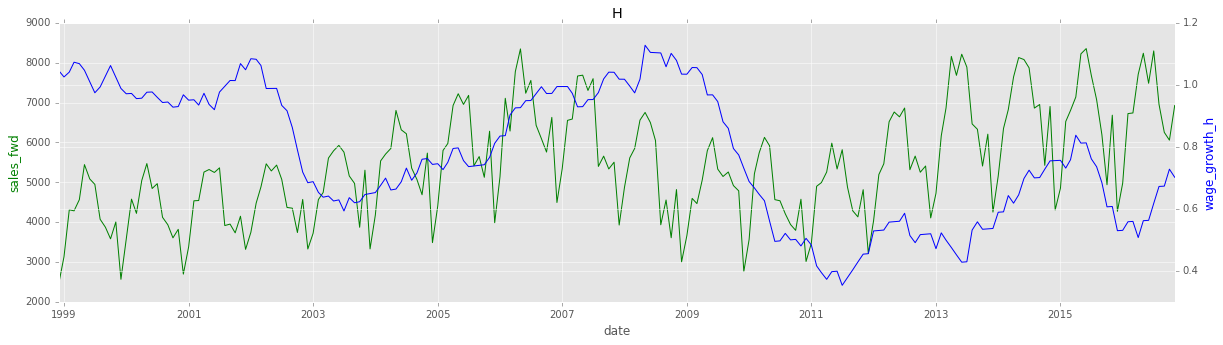

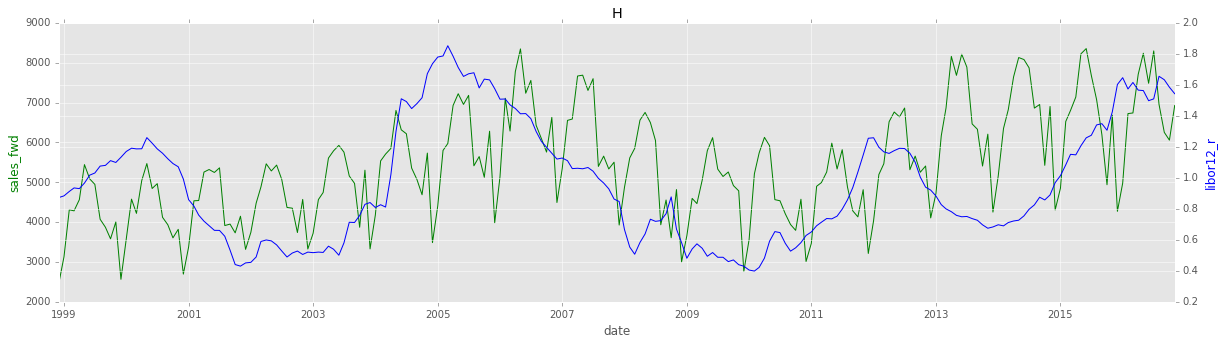

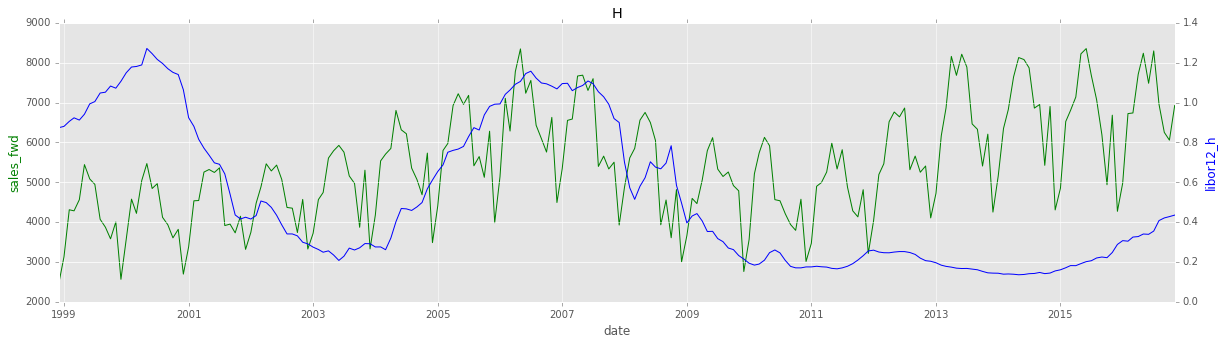

In [57]:
# plot features against label
for m in ['H']:
    dt=data[data['msa_key']==m]
    for f in features:
    
        x = dt['date_key']
        y1 = dt['sales_fwd']
        y2 = dt[f]

        fig, ax1 = plt.subplots(figsize=(20,5)) 
        ax2 = ax1.twinx() 
        ax1.plot(x, y1, 'g-') 
        ax2.plot(x, y2, 'b-') 
        ax1.set_xlabel('date') 
        ax1.set_ylabel('sales_fwd', color='g') 
        ax2.set_ylabel(f, color='b')
        plt.title(m)
        plt.show()

In [49]:
# correlation matrix for feature selections
data[data['msa_key']=='H'][['sales_fwd']+features].corr(method='pearson').sort_index()

sales_fwd   p_med_g  employmentTotal_g  population_g  \
employmentTotal_g    0.153990 -0.059097           1.000000      0.085859   
employmentTotal_h    0.470797  0.058864           0.331826      0.040328   
employmentTotal_r    0.160809 -0.029206           0.907181      0.169002   
f1units_g            0.038106  0.425013           0.076403     -0.036372   
f1units_h            0.274711  0.247348          -0.108428      0.148249   
f1units_r            0.385080  0.391241           0.115386     -0.037087   
f24units_g           0.075476  0.094356           0.100867      0.162775   
f24units_h          -0.017334  0.125905          -0.061827      0.181221   
f24units_r           0.137524  0.180784           0.106227      0.161592   
f5units_g            0.052674  0.057189           0.320616      0.088765   
f5units_h            0.127173  0.102017           0.107306      0.170698   
f5units_r            0.030644  0.023341           0.288600      0.130709   
hh_inc_g             0.110143 -0.039179           0.070865      0.315814   
hh_inc_h             0.444776  0.049414           0.103886      0.055550   
hh_inc_r             0.210753  0.042021           0.075473      0.211689   
libor12_g            0.253843  0.156640           0.113698     -0.175511   
libor12_h           -0.114934  0.154231          -0.128886      0.135975   
libor12_r            0.321797  0.105326          -0.006999     -0.098684   
months_inventory_g  -0.172457 -0.298825          -0.342262     -0.214025   
months_inventory_h  -0.109061 -0.689042           0.206386     -0.115685   
months_inventory_r  -0.044369 -0.352231          -0.368164     -0.218671   
oil_p_g             -0.166969  0.146619           0.028479     -0.274972   
oil_p_h              0.204287 -0.174181           0.492809      0.119540   
oil_p_r             -0.093033  0.127865           0.121576     -0.229063   
p_med_g              0.104445  1.000000          -0.059097     -0.023128   
p_med_h              0.671598  0.235000          -0.048122      0.092710   
p_med_r              0.350012  0.655272          -0.044434      0.025057   
population_g         0.169135 -0.023128           0.085859      1.000000   
population_h         0.502405 -0.102685           0.256160      0.054689   
population_r         0.299770 -0.016907           0.062909      0.407417   
sales_fwd            1.000000  0.104445           0.153990      0.169135   
unemploymentRate_g  -0.267853 -0.236559          -0.569552      0.063904   
unemploymentRate_h  -0.144455 -0.380025           0.105473     -0.188567   
unemploymentRate_r  -0.237348 -0.285272          -0.488093     -0.007110   
wage_growth_g        0.240068  0.170964           0.132533      0.438305   
wage_growth_h       -0.196110  0.024864          -0.364556      0.327088   
wage_growth_r        0.303514  0.300169           0.075292      0.431895   

                     oil_p_g  hh_inc_g  months_inventory_g  f1units_g  \
employmentTotal_g   0.028479  0.070865           -0.342262   0.076403   
employmentTotal_h  -0.383717  0.132077           -0.322599  -0.068710   
employmentTotal_r   0.025370  0.135621           -0.426784   0.064432   
f1units_g           0.114557 -0.130853           -0.336050   1.000000   
f1units_h           0.197639  0.002401            0.066373   0.412780   
f1units_r           0.065166 -0.032265           -0.303258   0.687865   
f24units_g          0.030821  0.075038           -0.055061   0.085770   
f24units_h          0.095253  0.126413            0.038846  -0.018013   
f24units_r         -0.031933  0.060333           -0.111485   0.091592   
f5units_g           0.012583 -0.078448           -0.099620   0.133515   
f5units_h          -0.032628  0.081701           -0.094792   0.003560   
f5units_r           0.002248  0.003326           -0.141251   0.125911   
hh_inc_g           -0.186017  1.000000           -0.230703  -0.130853   
hh_inc_h           -0.455764  0.344882           -0.224046  -0.194323   
hh_inc_r           -0.181739  0.8660

In [50]:
# hand pick initial features in each category based on correlation matrix
feature_select = ['employmentTotal_h', 'f1units_r', 'f24units_r', 'f5units_h', 'hh_inc_h', 'libor12_r', 'months_inventory_g',\
                  'oil_p_h', 'p_med_h', 'population_h', 'unemploymentRate_g', 'wage_growth_r']
# one-hot encode categorical features
cat_col_to_encode = ['msa_key','month']
cat_dummy_col = dict()
for c in cat_col_to_encode:
    dummy = pd.get_dummies(data[c])
    cat_dummy_col[c] = ['month_' + str(i) if c == 'month' else i.encode('ascii','ignore')\
                      for i in dummy.columns.tolist() ]
    dummy.columns =  ['month_' + str(i) if c == 'month' else i.encode('ascii','ignore')\
                      for i in dummy.columns.tolist() ]   
    data = data.join(dummy)
# index by year
data = data.set_index('year')

# train model & parameter tuning

In [51]:
# split training vs test set
# there are total 18 years of data, split into 70/20/10 for train/cv/test
df_train, df_cv, df_test = [data.loc[data.index<=2014], data.loc[(data.index>2014)&(data.index<=2015)], data.loc[data.index>2015]]
msa_train,msa_cv,msa_test = [data.loc[data.index<=2014,'msa_key'], data.loc[(data.index>2014)&(data.index<=2015),'msa_key'], data.loc[data.index>2015,'msa_key']]
X_train, y_train = [df_train[feature_select+cat_dummy_col['month']+cat_dummy_col['msa_key']], df_train[label]]
X_cv, y_cv = [df_cv[feature_select+cat_dummy_col['month']+cat_dummy_col['msa_key']], df_cv[label]]
X_test, y_test = [df_test[feature_select+cat_dummy_col['month']+cat_dummy_col['msa_key']], df_test[label]]
print 'number of obs in traning set: %s' % X_train.shape[0]
print 'number of obs in cross validation set: %s' % X_cv.shape[0]
print 'number of obs in test set: %s' % X_test.shape[0]

number of obs in traning set: 579
number of obs in cross validation set: 36
number of obs in test set: 33


optimal regularization parameter with maximized prediction accuracy for Houston MSA is 0.471375313412 with MAPE: 0.134751049528


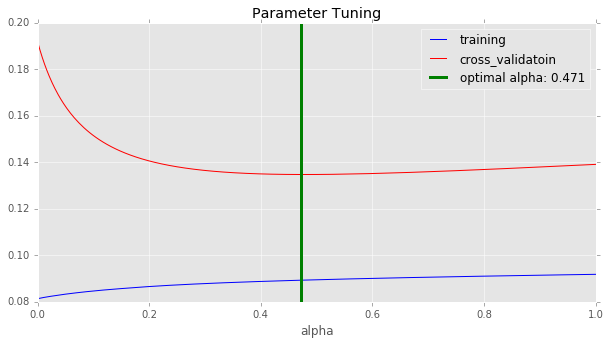

In [58]:
# train ridge regression with parameter tuning 
from sklearn.linear_model import Ridge
from operator import itemgetter
n_alphas = 200
alphas = np.logspace(-5, 0, n_alphas)
#mape_r = []
train_mape = []
cv_mape = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha,fit_intercept=False, normalize=True)
    ridge.fit(X_train,y_train)
    y_pred_train = ridge.predict(X_train)
    y_pred_cv = ridge.predict(X_cv)
    houston_cv=pd.concat([msa_cv,y_cv], axis=1)
    houston_cv['y_pred_cv']=y_pred_cv
    houston_cv['ape'] = abs(y_pred_cv-y_cv)/y_cv
    houston_train=pd.concat([msa_train,y_train], axis=1)
    houston_train['y_pred_train']=y_pred_train
    houston_train['ape'] = abs(y_pred_train-y_train)/y_train
    cv_mape.append(houston_cv[houston_cv['msa_key']=='H'][['msa_key','ape']].groupby('msa_key').mean().values[0][0])
    train_mape.append(houston_train[houston_train['msa_key']=='H'][['msa_key','ape']].groupby('msa_key').mean().values[0][0])

print 'optimal regularization parameter with maximized prediction accuracy for Houston MSA is %s with MAPE: %s' \
% min(zip(alphas, cv_mape),key=itemgetter(1))

# plot training error and cv error change with alpha
alpha=min(zip(alphas, cv_mape),key=itemgetter(1))[0]
x = alphas
y1 = train_mape
y2 = cv_mape
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y1, 'b-', label='training') 
ax.plot(x, y2, 'r-', label='cross_validatoin') 
ax.set_xlabel('alpha') 
ax1.set_ylabel('MAPE', color='b') 
plt.axvline(alpha, color='g', linewidth=3,
                label='optimal alpha: %s' % round(alpha,3))
plt.legend(loc='best')
plt.title('Parameter Tuning')
plt.show()

# model performance on test set

mean average percentage error for Houston MSA is 0.214030117831
mean average percentage error for Dallas MSA is 0.180304824574
mean average percentage error for San Antonio MSA is 0.263168999966


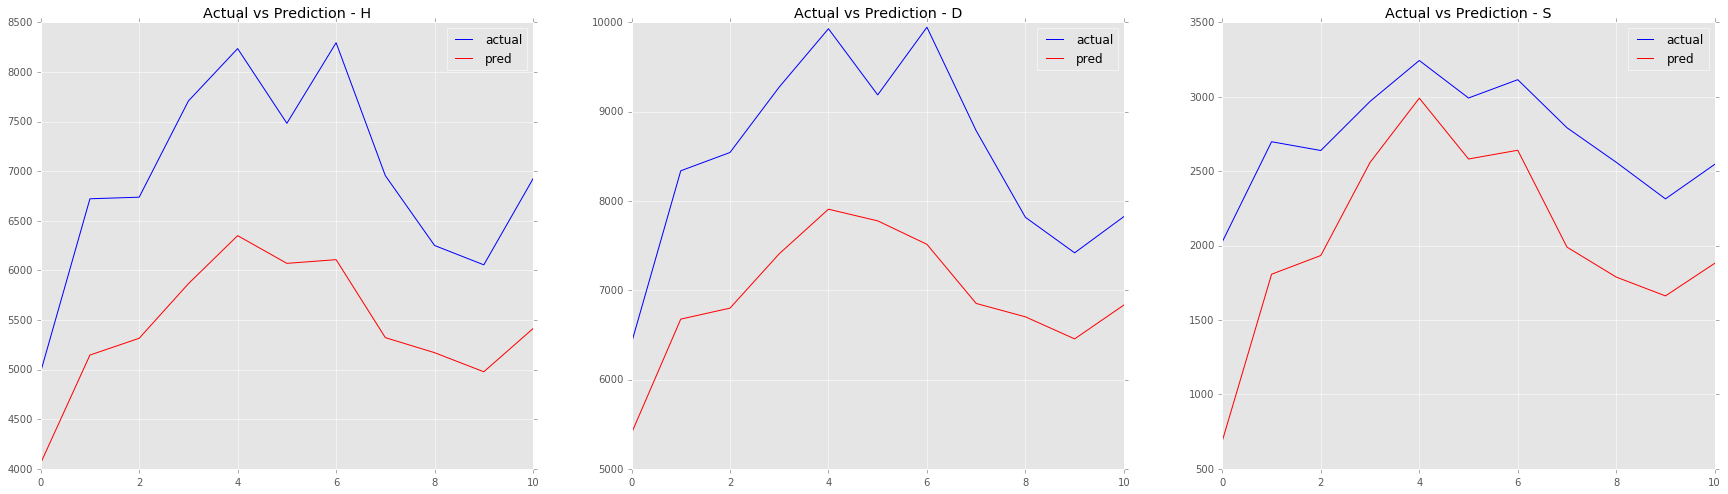

In [59]:
# test model performance on test set
ridge = Ridge(alpha= min(zip(alphas, cv_mape),key=itemgetter(1))[0],fit_intercept=False, normalize=True)
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_test)
test_result = pd.concat([msa_test,y_test],axis=1)
test_result['y_pred'] = y_pred
test_result['MAPE'] = abs(y_pred-y_test)/y_test
test_perf=test_result[['msa_key','MAPE']].groupby('msa_key').mean().reset_index()
print 'mean average percentage error for Houston MSA is %s' % test_perf[test_perf['msa_key']=='H']['MAPE'].values[0]
print 'mean average percentage error for Dallas MSA is %s' % test_perf[test_perf['msa_key']=='D']['MAPE'].values[0]
print 'mean average percentage error for San Antonio MSA is %s' % test_perf[test_perf['msa_key']=='S']['MAPE'].values[0]

fig, ax = plt.subplots(figsize=(30, 8), nrows=1, ncols=3)
for i in range(3):
    k=['H', 'D', 'S'][i]
    x = test_result[test_result['msa_key']==k].reset_index().index
    y1 = test_result[test_result['msa_key']==k].reset_index()['sales_fwd']
    y2 = test_result[test_result['msa_key']==k].reset_index()['y_pred']
    plt.subplot(1,3,i+1)
    plt.plot(x, y1, 'b-', label='actual') 
    plt.plot(x, y2, 'r-', label='pred')
    plt.legend(loc='best')
    plt.title('Actual vs Prediction - '+k)
plt.show()